In [200]:
train_file_path = r"D:\Data Science\Projects\ML-House_Price_Prediction\housing\artifact\data_ingestion\2023-08-17-10-30-20\ingested_data\train\housing.csv"

In [201]:
import pandas as pd

In [202]:
train_df = pd.read_csv(train_file_path)

In [203]:
train_df.shape

(16512, 10)

In [204]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [205]:
x_train,y_train = train_df.drop(columns=["median_house_value"],axis=1),train_df[["median_house_value"]]

In [206]:
x_train.shape,y_train.shape

((16512, 9), (16512, 1))

In [207]:
x_train.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [208]:
x_numerical_columns = x_train.drop(columns=["ocean_proximity"],axis=1)

In [209]:
x_numerical_columns.shape

(16512, 8)

In [210]:
x_numerical_columns.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [211]:
from sklearn.impute import SimpleImputer

In [212]:
simple_imputer = SimpleImputer(strategy="median")

In [213]:
simple_imputer.fit_transform(x_numerical_columns)

array([[-1.2146e+02,  3.8520e+01,  2.9000e+01, ...,  2.2370e+03,
         7.0600e+02,  2.1736e+00],
       [-1.1723e+02,  3.3090e+01,  7.0000e+00, ...,  2.0150e+03,
         7.6800e+02,  6.3373e+00],
       [-1.1904e+02,  3.5370e+01,  4.4000e+01, ...,  6.6700e+02,
         3.0000e+02,  2.8750e+00],
       ...,
       [-1.2272e+02,  3.8440e+01,  4.8000e+01, ...,  4.5800e+02,
         1.7200e+02,  3.1797e+00],
       [-1.2270e+02,  3.8310e+01,  1.4000e+01, ...,  1.2080e+03,
         5.0100e+02,  4.1964e+00],
       [-1.2214e+02,  3.9970e+01,  2.7000e+01, ...,  6.2500e+02,
         1.9700e+02,  3.1319e+00]])

In [215]:
train_df = simple_imputer.transform(x_numerical_columns)

In [216]:
simple_imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [217]:
simple_imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [218]:
x_train.ocean_proximity.value_counts()

<1H OCEAN     7277
INLAND        5262
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [219]:
from sklearn.base import BaseEstimator,TransformerMixin

In [220]:
class test(BaseEstimator,TransformerMixin):
    def __init__(self,strategy="median"):
        self.strategy = strategy
    def fit(self,x):
        self.features_ = x.columns
        self.statistics_ = []
        for column in self.features_:
            self.statistics_.append(x[column].median())
        return self
    def transform(self,x:pd.DataFrame):
        for idx,column in enumerate(x.columns):
            x[column].fillna(self.statistics_[idx])
        return x
    #def fit_transform(self, x):
    #    self.fit(x)
    #    self.transform(x)

In [221]:
test().fit(x_numerical_columns).statistics_

[-118.51, 34.26, 29.0, 2119.0, 433.0, 1164.0, 408.0, 3.54155]

In [222]:
x_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [223]:
import numpy as np
COLUMN_TOTAL_ROOMS = "total_rooms"
COLUMN_POPULATION = "population"
COLUMN_HOUSEHOLDS = "households"
COLUMN_TOTAL_BEDROOM = "total_bedrooms"

class featuregenerator(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedroom_per_room = True,
                 total_rooms_ix= 3,
                 population_ix= 5,
                 households_ix= 6,
                 total_bedrooms_ix= 4,
                 columns= None):
        """
        FeatureGenerator Initialization
        add_bedrooms_per_room: bool
        total_rooms_ix: int index number of total rooms columns
        population_ix: int index number of total population columns
        households_ix: int index number of households columns
        total_bedrooms_ix: int index number of total bedrooms columns
        """
        try:
            self.columns = columns
            if self.columns is not None:
                total_rooms_ix = self.columns.index(COLUMN_TOTAL_ROOMS)
                population_ix = self.columns.index(COLUMN_POPULATION)
                households_ix = self.columns.index(COLUMN_HOUSEHOLDS)
                total_bedrooms_ix = self.columns.index(COLUMN_TOTAL_BEDROOM)
            self.add_bedroom_per_room = add_bedroom_per_room
            self.total_rooms_ix = total_rooms_ix
            self.population_ix = population_ix
            self.households_ix = households_ix
            self.total_bedrooms_ix = total_bedrooms_ix
        except Exception as e:
            raise e
    def fit(self,x,y=None):
        return self
    def transform(self,x,y=None):
        try:
            room_per_household = x[:,self.total_rooms_ix]/x[:, self.households_ix]
            population_per_household = x[:,self.population_ix]/x[:,self.households_ix]
            if self.add_bedroom_per_room:
                bedroom_per_room = x[:,self.total_bedrooms_ix]/x[:,self.total_rooms_ix]
                generated_feature = np.c_[x,room_per_household,population_per_household,bedroom_per_room]
            else:
                generated_feature = np.c_[x,room_per_household,population_per_household]
            return generated_feature
        except Exception as e:
            raise e

In [224]:
arr1 = np.arange(10)
arr2 = np.arange(10)
arr1,arr2

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [225]:
np.c_[arr1,arr2]

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5],
       [6, 6],
       [7, 7],
       [8, 8],
       [9, 9]])

In [226]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [227]:
num_pipeline = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy='median')),
    ('feature_generator',featuregenerator()),
    ('scaling',StandardScaler())
])

In [228]:
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('feature_generator', featuregenerator()),
                ('scaling', StandardScaler())])

In [229]:
from sklearn.preprocessing import OneHotEncoder

In [230]:
cat_pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('OneHotEncoder',OneHotEncoder()),
    ('scaling',StandardScaler(with_mean=False))
])

In [231]:
cat_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('OneHotEncoder', OneHotEncoder()),
                ('scaling', StandardScaler(with_mean=False))])

In [235]:
train_df = pd.read_csv(train_file_path)

In [236]:
train_df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [237]:
num_column_name = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']
cat_column_name = ['ocean_proximity']

In [238]:
preprocessing = ColumnTransformer([
    ('num_pipeline',num_pipeline,num_column_name),
    ('cat_pipeline',cat_pipeline,cat_column_name)
])

In [239]:
train_arr = preprocessing.fit_transform(train_df)

In [240]:
test_df = pd.read_csv(r"D:\Data Science\Projects\ML-House_Price_Prediction\housing\artifact\data_ingestion\2023-08-17-10-30-20\ingested_data\test\housing.csv")

In [241]:
test = preprocessing.transform(test_df)

In [242]:
import dill

In [243]:
with open('preprocessing.pkl',"wb") as prep_file:
    dill.dump(preprocessing,prep_file)

In [244]:
with open('preprocessing.pkl',"rb") as prep_file:
    prep_loaded_obj = dill.load(prep_file)

In [245]:
prep_loaded_obj.transform(test_df)

array([[ 0.59229422, -0.71065803,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42180959, -0.35049119, -0.37006852, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56232071, -0.64985064,  0.5842485 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.07211862, -0.56097831,  1.14093342, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.83208232, -0.93985512,  0.10708999, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.50736927, -0.67791559,  0.5842485 , ...,  0.        ,
         0.        ,  0.        ]])

In [247]:
test

array([[ 0.59229422, -0.71065803,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42180959, -0.35049119, -0.37006852, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56232071, -0.64985064,  0.5842485 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.07211862, -0.56097831,  1.14093342, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.83208232, -0.93985512,  0.10708999, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.50736927, -0.67791559,  0.5842485 , ...,  0.        ,
         0.        ,  0.        ]])

In [248]:
from sklearn.linear_model import LinearRegression

In [249]:
lr = LinearRegression()

In [250]:
train_arr.shape,test.shape

((16512, 17), (4128, 17))

In [252]:
x = train_arr
y = np.array(train_df.median_house_value)

In [253]:
lr.fit(x,y)

LinearRegression()

In [254]:
lr.fit_intercept

True

In [255]:
lr.coef_

array([-6.84374017e-11,  2.27373675e-11, -2.78809981e-11, -9.27614547e-11,
        1.23293781e-10,  1.14638824e-11, -8.63611208e-11,  2.68724874e-11,
        1.15697794e+05, -1.33084988e-12, -2.06857261e-11, -1.64969833e-11,
        1.38498376e+01,  1.29987541e+01,  3.07000144e-01,  8.79274597e+00,
        9.33958363e+00])

In [256]:
lr.intercept_

206977.42587121215

In [257]:
y_hat= lr.predict(x)

In [258]:
import matplotlib.pyplot as plt

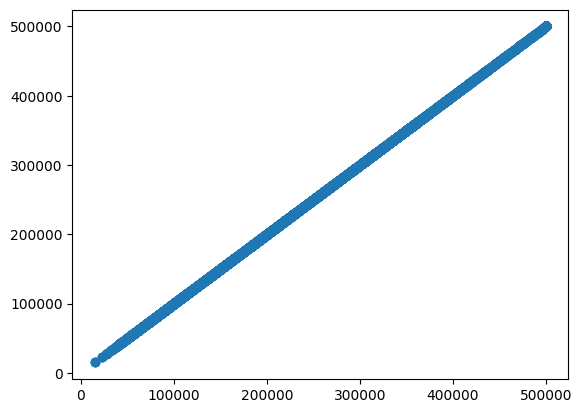

In [259]:
plt.plot(y,y_hat,'o')

In [260]:
from sklearn.metrics import r2_score

In [261]:
r2_score(y,y_hat)

1.0

In [263]:
yhat_test = lr.predict(test)

In [264]:
y_test = np.array(test_df.median_house_value)

In [265]:
r2_score(y_test,yhat_test)

1.0